# Assignment 2

In [1]:
from PIL import Image, ImageDraw
import numpy as np
import math
from scipy import signal
import ncc
import matplotlib.pyplot as plt

## Part 1: Face Detection in a Scaled Representation

### Question 2

In [2]:
def make_pyramid(image, minsize):
    # initial image and dimensions
    pyramid = [image]
    width, height = image.size
    
    # while both h,w are larger than minsize
    while height >= minsize and width >= minsize:
        # resize image w/ 0.75 scale using bicubic interpolation
        dim = (int(width*0.75), int(height*0.75))
        image = image.resize(dim, Image.BICUBIC)
        # update new height and width
        width, height = image.size
        # add resized image to pyramid
        pyramid.append(image)
        
    return pyramid

### Question 3

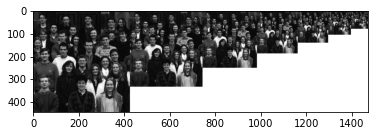

In [3]:
def show_pyramid(pyramid):
    # set height and width of pyramid image
    height = pyramid[0].size[1]
    widths = []
    for img in pyramid:
        widths.append(img.size[0])
    collage = Image.new("L", (sum(widths), height), 255)
    
    for idx,img in enumerate(pyramid):
        # offset by sum of prev widths
        offset_x = sum(widths[:idx])
        # paste imgs to pyramid img
        collage.paste(img, (offset_x, 0))
    
    # show the pyramid image 
    plt.imshow(collage, cmap="gray")
    plt.show()

image = Image.open("faces/students.jpg")
pyramid = make_pyramid(image, 100)
show_pyramid(pyramid)

### Question 4

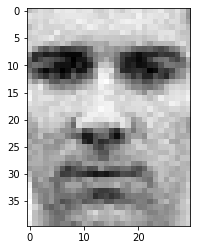

In [39]:
# create a template with new width, scaling height equivalently
def create_template(width):
    t = Image.open("faces/template.jpg")
    scale = width/t.width
    template = t.resize((int(t.width*scale), int(t.height*scale)), Image.BICUBIC)
    return template

def find_template(pyramid, template, threshold):
    face_points = []
    for idx,img in enumerate(pyramid):
        # normalized corss correlation on image and face-template
        ncc_array = ncc.normxcorr2D(img, template)
        # iterate through pixles
        for x in range(img.width):
            for y in range(img.height):
                # check its value against the threshold
                if ncc_array[y][x] > threshold:
                    # append to face_points if above given threshold
                    face_points.append((x/(0.75**idx), y/(0.75**idx)))
    return face_points

def draw_bounding_boxes(image,face_points):
    # convert image to RGB for red box
    image = image.convert("RGB")
    # make 20x25 rectangles around face points
    for p in face_points:
        draw = ImageDraw.Draw(image)
        x1 = p[0]-20
        x2 = p[0]+20
        y1 = p[1]-25
        y2 = p[1]+25
        draw.line((x1,y1,x1,y2),fill="red",width=2)
        draw.line((x2,y1,x2,y2),fill="red",width=2)
        draw.line((x1,y1,x2,y1),fill="red",width=2)
        draw.line((x1,y2,x2,y2),fill="red",width=2)
        del draw
    # show image
    plt.imshow(image)
    plt.show()
    
template15 = create_template(30)
plt.imshow(template15, cmap="gray")
plt.show()

### Question 5

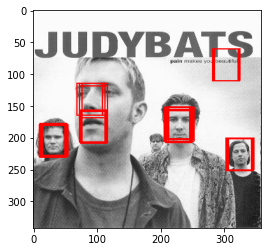

Error rate: 2/1
Recall rate: 4/5 = 0.8


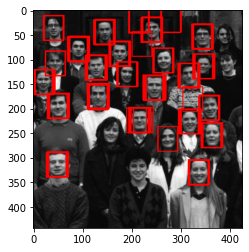

Error rate: 4/4
Recall rate: 23/27 = 0.85


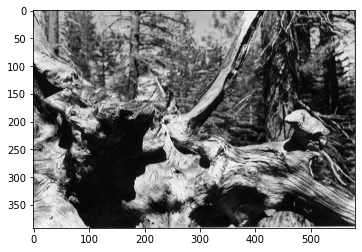

Error rate: 0/0
Recall rate: 0/0 = 1


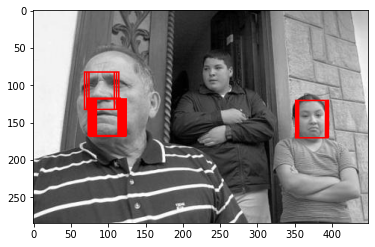

Error rate: 1/1
Recall rate: 2/3 = 0.66


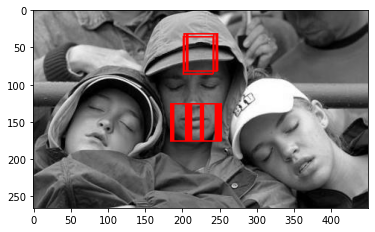

Error rate: 3/3
Recall rate: 0/3 = 0


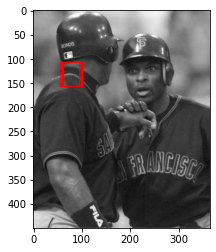

Error rate: 1/2
Recall rate: 0/1 = 0


In [38]:
image = Image.open("faces/judybats.jpg")
pyramid = make_pyramid(image, 100)
face_points = find_template(pyramid, template15, 0.55)
draw_bounding_boxes(pyramid[0], face_points)
print("Error rate: 2/1")
print("Recall rate: 4/5 = 0.8")

image = Image.open("faces/students.jpg")
pyramid = make_pyramid(image, 100)
face_points = find_template(pyramid, template15, 0.57)
draw_bounding_boxes(pyramid[0], face_points)
print("Error rate: 4/4")
print("Recall rate: 23/27 = 0.85")

image = Image.open("faces/tree.jpg")
pyramid = make_pyramid(image, 100)
face_points = find_template(pyramid, template15, 0.7)
draw_bounding_boxes(pyramid[0], face_points)
print("Error rate: 0/0")
print("Recall rate: 0/0 = 1")

image = Image.open("faces/family.jpg")
pyramid = make_pyramid(image, 100)
face_points = find_template(pyramid, template15, 0.55)
draw_bounding_boxes(pyramid[0], face_points)
print("Error rate: 1/1")
print("Recall rate: 2/3 = 0.66")

image = Image.open("faces/fans.jpg")
pyramid = make_pyramid(image, 100)
face_points = find_template(pyramid, template15, 0.62)
draw_bounding_boxes(pyramid[0], face_points)
print("Error rate: 3/3")
print("Recall rate: 0/3 = 0")

image = Image.open("faces/sports.jpg")
pyramid = make_pyramid(image, 100)
face_points = find_template(pyramid, template15, 0.51)
draw_bounding_boxes(pyramid[0], face_points)
print("Error rate: 1/2")
print("Recall rate: 0/1 = 0")

### Question 6
As you can see, the NCC method performed very poorly on the last two images. This is because the faces in the picture do not match the given template well. 

In the image of fans, all three faces have their eyes closed. This results in a lower correlation with the template face, since the template's eyes are dark and the fan's eyelids are light. Additionally, the two faces on the left and right are not exactly vertical. Since we only adjusted for scale, the NCC algorithm can recognize faces of different sizes, but not when they are rotated. Accounting for rotations while using template matching is infeasible in practice, due to the number of different degrees an object can be rotated (i.e. 360).

In the last image, the baseball player is wearing a batting helmet that obstructs his face. More importantly, however, NCC introduces racial biases. The template face has lighter skin, while the baseball player has darker skin. Due to the darker color of the baseball player's skin, his face does not correlate well with the template, meaning the NCC algorithm is not able to recognize his face at all.